###At what point in high school do students give up on math? Identifying knowledge gaps in high school and college math education using Stack Exchange's Math forum

#### Additional Questions:
    1. What are the most popular subjects over time? (Upvotes, Favorites and Views)
    2. What are the most hotly debated subjects over time? (Comment Count, Longevity)
    3. What are the most fundamental subjects students are asking about over time? (Asked multiple times, answered quickly and by only a few commenters)
    4. What are the demographics of the posters and commenters? (Education level, age and location)
    5. Who are the most active math people? How quickly do they reply? Who has way too much free time?
    6. Can I determine sex from username?

In [1]:
import numpy as np
import pandas as pd

from xml.etree import ElementTree as ET
from HTMLParser import HTMLParser

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

#Parse Stackoverflow XML files

In [161]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [162]:
etree = ET.parse('Data/Math/math.stackexchange.com/Posts.xml')
root = etree.getroot()
i = 0
postdicts = []
for x in root.iter():
    postdicts.append(x.attrib)
postdata = pd.DataFrame(postdicts).ix[1:]

In [163]:
for index, row in postdata.iterrows():
    row['Body'] = strip_tags(row['Body'])

In [164]:
etree = ET.parse('Data/Math/math.stackexchange.com/Users.xml')
root = etree.getroot()
i = 0
userdicts = []
for x in root.iter():
    userdicts.append(x.attrib)
userdata = pd.DataFrame(userdicts).ix[1:]

#Where are the users?

In [165]:
location2 = userdata['Location']

In [166]:
userdata.replace(to_replace=['Bangalore, India','London, United Kingdom','New York, United States','San Francisco, CA','Mumbai, India','Paris, France','Sydney, Australia','Toronto, Canada','Moscow, Russia','Chennai, India','Los Angeles, CA','Berlin, Germany','Montreal, Canada','Melbourne, Australia','Hyderabad, India','Pune, India','Beijing, China','Vancouver, Canada','Stockholm, Sweden','Kolkata, India','New Delhi, India','UK','London'], 
                 value=['India','United Kingdom','New York, NY','California','India','France','Australia','Canada','Russia','India','California','Germany','Canada','Australia','India','India','China','Canada','Sweden','India','India','United Kingdom','United Kingdom'],inplace=True)

In [167]:
userdata.replace(to_replace=['California','New York, NY','Seattle, WA','Boston, MA','Chicago, IL','Austin, TX','Atlanta, GA','Pittsburgh, PA','Portland, OR','USA','San Diego, CA','Berkeley, CA'],value='United States',inplace=True)

In [168]:
userdata['Location2'] = location2
userdata.columns

Index([u'AboutMe', u'AccountId', u'Age', u'CreationDate', u'DisplayName', u'DownVotes', u'Id', u'LastAccessDate', u'Location', u'ProfileImageUrl', u'Reputation', u'UpVotes', u'Views', u'WebsiteUrl', u'Location2'], dtype='object')

In [169]:
def counter(x):
    x['Counter'] = x.Location.count()
    return x
counts = userdata.groupby("Location").apply(counter)
counts2 = counts[['Location','Counter']]
counts3 = counts2.drop_duplicates(cols='Location',take_last = True)
counts3.sort(columns='Counter',ascending=False,inplace=True)
counts4 = counts3[['Location','Counter']]
# userdata2.sort(columns='',ascending=False,inplace=True)

In [170]:
counts4.head(30)

,Location,Counter
171513,United States,3945
171322,India,2706
171622,United Kingdom,1482
171489,Germany,902
171132,Canada,877
171559,Australia,623
170315,France,576
171718,Russia,462
167586,Sweden,382
171098,Netherlands,325


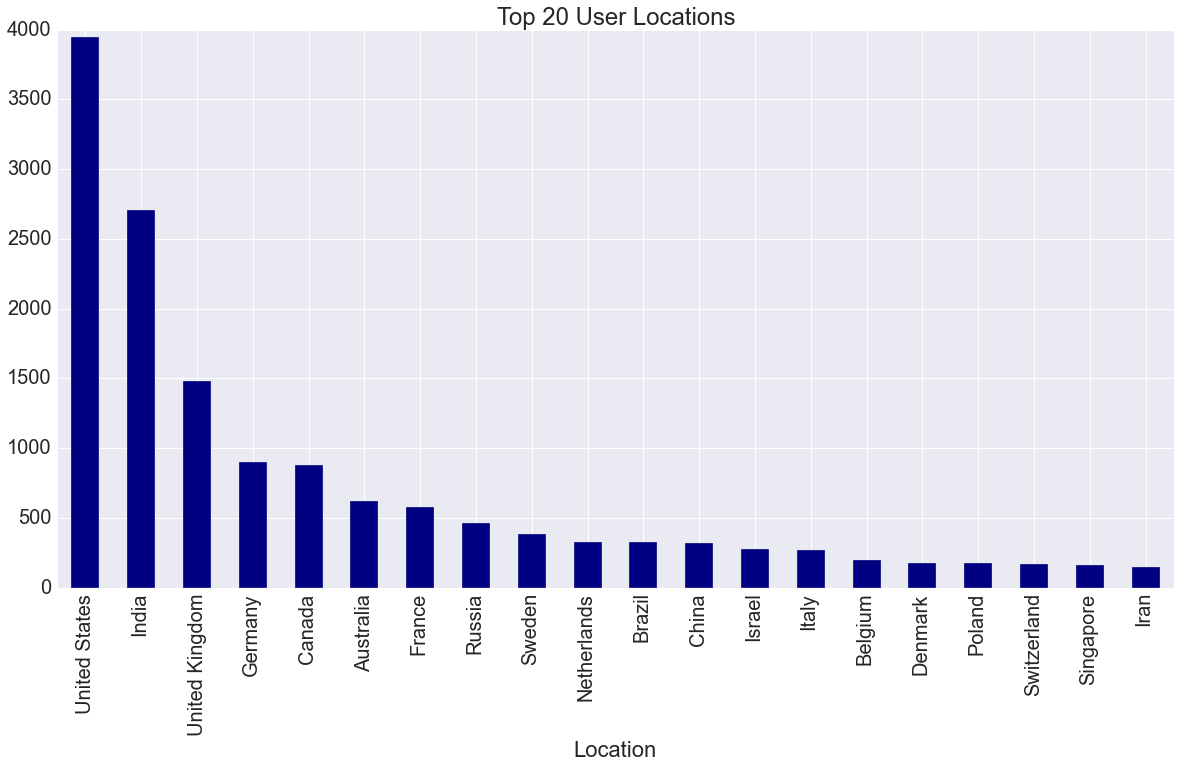

In [171]:
# Who are the users of the Math Forum?
sns.set_palette("deep", desat=.8)
sns.set(font_scale=2.0)
sns.set_context(rc={"figure.figsize": (20, 10)})   
ax = counts4[0:20].plot(x='Location', y='Counter',kind='bar',colormap='jet',title='Top 20 User Locations',legend=False)

In [172]:
postdata = pd.merge(postdata, userdata, left_on='OwnerUserId', right_on='Id', how='left')

In [173]:
etree = ET.parse('Data/Math/math.stackexchange.com/Comments.xml')
root = etree.getroot()
i = 0
commentdicts = []
for x in root.iter():
    commentdicts.append(x.attrib)
commentdata = pd.DataFrame(commentdicts).ix[1:]

In [174]:
for index, row in commentdata.iterrows():
    row['Text'] = strip_tags(row['Text'])

In [175]:
commentdata = pd.merge(commentdata, userdata, left_on='UserId', right_on='Id', how='left')

In [176]:
postdata.CreationDate_x = pd.to_datetime(postdata.CreationDate_x)
postdata.LastActivityDate = pd.to_datetime(postdata.LastActivityDate)

In [177]:
postdata['Longevity'] = postdata.LastActivityDate - postdata.CreationDate_x

In [178]:
LongevitySeconds = []
for row in postdata.Longevity:
    LongevitySeconds.append(row.total_seconds())
postdata['LongevitySeconds'] = LongevitySeconds

In [179]:
# Pull out tags
postdata.Tags = postdata.Tags.str.replace('\\<', '')
postdata.Tags = postdata.Tags.str.replace('\\>', ',')
postdata.Tags[0:10]

0                            set-theory,intuition,faq,
1                          calculus,limits,definition,
2             soft-question,big-list,online-resources,
3                                                  NaN
4                    number-theory,irrational-numbers,
5                         soft-question,math-software,
6                                                  NaN
7    linear-algebra,combinatorics,generating-functi...
8                                                  NaN
9               algebra-precalculus,decimal-expansion,
Name: Tags, dtype: object

In [180]:
removenans = postdata.Tags
removenans = removenans.fillna('')
postdata.Tags = removenans
postdata.Tags = postdata.Tags.str.strip(',')

In [181]:
postdata['BodyLength'] = postdata['Body'].str.len()
print postdata['BodyLength'][0:10]

0     269
1      71
2      72
3     191
4     196
5     117
6     285
7     392
8    1490
9     122
Name: BodyLength, dtype: int64


In [182]:
# Get unique list of subjects and their counts
subjectlist = []
for row in postdata.Tags:
    for subject in row.split(','):
        subjectlist.append(subject)

In [183]:
from collections import Counter
counts = Counter(subjectlist)

In [184]:
taglist = []
tagcounts = []
for word, count in counts.iteritems():
    taglist.append(word)
    tagcounts.append(count)
uniquetaglist = zip(*[taglist,tagcounts])
uniquetags = pd.DataFrame(uniquetaglist)
uniquetags.columns = ['Tag','Count']
uniquetags.sort(columns='Count',ascending=False,inplace=True)

In [185]:
# Modify with high-school, non-high school values in Excel
# uniquetags.to_csv('uniquetags.csv')

In [186]:
uniquetags2 = uniquetags.from_csv('uniquetags.csv',header = 0)

In [187]:
uniquetags2.columns

Index([u'Tag', u'Count', u'HighSchoolSubjects'], dtype='object')

In [188]:
highschoolbinary = uniquetags2['HighSchoolSubjects'].tolist()
tagstemp = uniquetags2['Tag'].tolist()
subjectbinary = zip(*[tagstemp,highschoolbinary])
highschooltags = []
defnothighschooltags = []
for item in subjectbinary:
    if item[1] == 1:
        highschooltags.append(item[0])
    elif item[1] == 0:
        defnothighschooltags.append(item[0])
highschooltags[0:9]    
defnothighschooltags[0:9]

['real-analysis',
 'linear-algebra',
 'probability',
 'abstract-algebra',
 'sequences-and-series',
 'general-topology',
 'combinatorics',
 'group-theory',
 'complex-analysis']

In [189]:
# Develop training set from subjects I am sure are 
# high-school or not high-school level
highschoolsubject = []
for row in postdata.Tags:
    if any(subject not in highschooltags for subject in row.split(',')):
        if any(subject in defnothighschooltags for subject in row.split(',')):
            highschoolsubject.append(0.0)
        else:
            highschoolsubject.append(0.5)
    elif any(subject not in defnothighschooltags for subject in row.split(',')):
        highschoolsubject.append(1.0)
    else:
        highschoolsubject.append(1)
    for subject in row.split(','):
        subjectlist.append(subject)
postdata['HighSchoolSubject'] = highschoolsubject

In [190]:
postdata[['Tags','HighSchoolSubject']][0:9]

,Tags,HighSchoolSubject
0,"set-theory,intuition,faq",0.0
1,"calculus,limits,definition",0.5
2,"soft-question,big-list,online-resources",0.5
3,,0.5
4,"number-theory,irrational-numbers",0.0
5,"soft-question,math-software",0.5
6,,0.5
7,"linear-algebra,combinatorics,generating-functi...",0.0
8,,0.5


In [191]:
postdata.AnswerCount = postdata.AnswerCount.fillna(0)
postdata.Longevity = postdata.Longevity.fillna(0)
postdata.FavoriteCount = postdata.FavoriteCount.fillna(0)
postdata.CommentCount = postdata.CommentCount.fillna(0)
postdata.ViewCount = postdata.ViewCount.fillna(0)
postdata.BodyLength = postdata.BodyLength.fillna(0)
for col in ['AnswerCount', 'FavoriteCount', 'CommentCount', 'ViewCount']:
    postdata[col] = postdata[col].astype(float)

### Pickle dataframe for posterity

In [192]:
# import pickle
# with open('StackOverflowPostData.pkl', 'w') as picklefile:
#     pickle.dump(postdata, picklefile)

###Unpickle

In [2]:
import pickle
with open("StackOverflowPostData.pkl", 'r') as picklefile: 
    postdata = pickle.load(picklefile)

#What are the most popular topics?

In [82]:
# %%timeit
things = ['LongevitySeconds', 'AnswerCount', 'FavoriteCount',
          'CommentCount', 'ViewCount', 'BodyLength']
results = {}
running_sum = 0
running_count = 0
for index in xrange(len(postdata)):
    tags = postdata.iloc[index]['Tags'].split(',')
    for tag in tags:
        for thing in things:
            value = postdata.iloc[index][thing]
            running_sum, running_count = results.setdefault(tag, {}).get(thing, (0, 0))
            results[tag][thing] = [running_sum + value, running_count + 1]

In [83]:
tagstats = pd.DataFrame.from_dict(results)
tagstats2 = tagstats.transpose()

In [84]:
Frequency = []
for row in tagstats2.AnswerCount:
    Frequency.append(row.pop())
print Frequency[0:10]

[596320, 9, 7, 814, 193, 957, 51, 73, 576, 22687]


In [85]:
for index in xrange(len(tagstats2)):
    for col in range(1,6):
        tagstats2.iloc[index][col].pop()

In [86]:
tagstats2.head()

,AnswerCount,BodyLength,CommentCount,FavoriteCount,LongevitySeconds,ViewCount
,[0.0],[422587540],[896301.0],[0.0],[360427361860.0],[0.0]
2-categories,[6.0],[6131],[8.0],[2.0],[6516330.828],[370.0]
2-groups,[6.0],[4762],[29.0],[17.0],[183307981.115],[772.0]
3d,[966.0],[617443],[1583.0],[254.0],[3962347268.74],[413932.0]
abelian-categories,[197.0],[150127],[443.0],[221.0],[777818719.881],[34933.0]


In [87]:
for index in xrange(len(tagstats2)):
    for col in range(0,6):
        tagstats2.iloc[index][col] = tagstats2.iloc[index][col][0]

In [88]:
tagstats2['Frequency'] = Frequency

In [89]:
tagstats2.LongevitySeconds = tagstats2.LongevitySeconds/3600.0

In [90]:
tagstats2.columns = ['AnswerCount','BodyLength','CommentCount','FavoriteCount','LongevityHours','ViewCount','Frequency']

In [91]:
tagstats2.head()

,AnswerCount,BodyLength,CommentCount,FavoriteCount,LongevityHours,ViewCount,Frequency
,0,422587540,896301,0,1.001187e+08,0,596320
2-categories,6,6131,8,2,1810.092,370,9
2-groups,6,4762,29,17,50918.88,772,7
3d,966,617443,1583,254,1100652,413932,814
abelian-categories,197,150127,443,221,216060.8,34933,193


In [92]:
toptopics = tagstats2[['Frequency','CommentCount','ViewCount','FavoriteCount']]
toptopics.CommentCount = toptopics.CommentCount / toptopics.Frequency
toptopics.ViewCount = toptopics.ViewCount / toptopics.Frequency
toptopics.FavoriteCount = toptopics.FavoriteCount / toptopics.Frequency
toptopics.sort(columns='ViewCount',ascending=False,inplace=True)

/usr/local/lib/python2.7/site-packages/pandas/core/generic.py:2005: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [93]:
toptopics2 = toptopics.apply(lambda c: c / c.sum() * 100, axis=0)
toptopics2['SumOfTotal'] = (toptopics2.Frequency + toptopics2.CommentCount + toptopics2.ViewCount + toptopics2.FavoriteCount) / 4.0

In [94]:
toptopics2.sort(columns='SumOfTotal',ascending=False,inplace=True)
toptopics2[1:21]

,Frequency,CommentCount,ViewCount,FavoriteCount,SumOfTotal
faq,0.003975,0.158527,1.563809,1.426973,0.788321
calculus,2.453872,0.099888,0.121150,0.074706,0.687404
big-list,0.055930,0.210802,0.922642,1.343721,0.633274
real-analysis,2.240752,0.096296,0.080328,0.067275,0.621163
differential-field,0.000279,0.181528,0.501039,1.747037,0.607471
linear-algebra,2.057551,0.089543,0.118755,0.044665,0.577628
fair-division,0.001674,0.139508,1.016114,1.112185,0.567370
music-theory,0.002441,0.162511,0.852564,0.887020,0.476134
probability,1.627685,0.081255,0.121350,0.038417,0.467177
abstract-algebra,1.582147,0.103705,0.077735,0.066250,0.457459


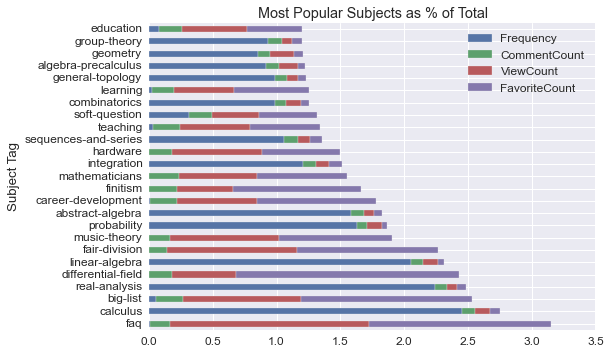

In [95]:
toptopics3 = toptopics2[['Frequency','CommentCount','ViewCount','FavoriteCount']]
sns.set(font_scale=1.2)   
sns.set_palette("deep", desat=.8)
ax = toptopics3[1:26].plot(kind='barh',stacked=True,title='Most Popular Subjects as % of Total',rot=0)
ax.set_ylabel("Subject Tag",rotation = 90)
sns.set_context(rc={"figure.figsize": (8, 20),'figure.facecolor':'cornflowerblue'})

# Create training set of subjects classified as highschool and non-highschool

In [65]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

sample_size = 10000

In [66]:
import pickle
with open("StackOverflowPostData.pkl", 'r') as picklefile: 
    postdata = pickle.load(picklefile)

In [67]:
postdata.replace(to_replace='\//', value='',inplace=True)

In [68]:
postdatadc2 = postdata[postdata.HighSchoolSubject != 0.5]

In [69]:
# IdsToRemove = ['639691','961354','355318']
# criterion = lambda row: row['Id_x'] not in IdsToRemove
# postdatadc2 = postdatadc[postdatadc.apply(criterion, axis=1)]
# len(postdatadc2)

In [70]:
import random

def some(x, n):
    return x.ix[random.sample(x.index, n)]
postdatadc3 = some(postdatadc2,sample_size)

In [71]:
unclassified = postdata[postdata.HighSchoolSubject == 0.5]
def some(x, n):
    return x.ix[random.sample(x.index, n)]
unclassified2 = some(unclassified,sample_size)

In [72]:
finaldf = postdatadc3.append(unclassified2, ignore_index=False, verify_integrity=False)

In [73]:
finaldf.reset_index(inplace=True)

In [74]:
finaldf = finaldf.drop('index', 1)

In [75]:
len(finaldf)

20000

##Create Tf-idf matrix
### Every question is a row, every column is a word

In [76]:
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [77]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        regex = re.compile('[^a-zA-Z]')
        cleaned = regex.sub('', token).rstrip()
        if len(cleaned) > 1:
            filtered_tokens.append(cleaned)
#         if re.search('[a-zA-Z]', token):
#             filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        regex = re.compile('[^a-zA-Z]')
        cleaned = regex.sub('', token).rstrip()
        if len(cleaned) > 1:
            filtered_tokens.append(cleaned)
#         if re.search('[a-zA-Z]', token):
#             filtered_tokens.append(token)
    return filtered_tokens

In [78]:
totalvocab_stemmed = []
totalvocab_tokenized = []
skipped_indexes = []
j = 0
for i in finaldf.Body:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    allwords_tokenized = tokenize_only(i)
    
    if len(allwords_stemmed) == len(allwords_tokenized):
        totalvocab_tokenized.extend(allwords_tokenized)
        totalvocab_stemmed.extend(allwords_stemmed)
    else:
#         print i
#         print "\n"
        skipped_indexes.append(j)
    j += 1    
    if j % 10000 == 0:
        print j
#     if len(totalvocab_tokenized) != len(totalvocab_stemmed):
#         print j, i, tokenize_only(i), tokenize_and_stem(i)
#         break

10000
20000


In [79]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

there are 1805596 items in vocab_frame


In [80]:
print skipped_indexes

[]


In [81]:
postdatadc4 = finaldf.drop(finaldf.index[skipped_indexes])

In [82]:
print len(postdatadc3)
print len(postdatadc4)

10000
20000


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df= 0.99,
                                 min_df= 0.001, 
                                 stop_words='english',
                                 use_idf=True, 
                                 tokenizer=tokenize_and_stem, 
                                 ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(postdatadc4.Body) #fit the vectorizer to body

print(tfidf_matrix.shape)

CPU times: user 2min 3s, sys: 2.5 s, total: 2min 6s
Wall time: 2min 6s
(20000, 5607)


In [84]:
tfidf_ml = tfidf_matrix[:sample_size]
tfidf_uc = tfidf_matrix[sample_size:] 

In [85]:
print tfidf_ml.shape
print tfidf_uc.shape

(10000, 5607)
(10000, 5607)


In [86]:
terms = tfidf_vectorizer.get_feature_names()

In [87]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

##Implement binary classifier with TFIDF matrix as features

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

In [90]:
postdataml = pd.SparseDataFrame([ pd.SparseSeries(tfidf_ml[i].toarray().ravel()) 
                              for i in np.arange(tfidf_ml.shape[0]) ])

In [91]:
postdatauc = pd.SparseDataFrame([ pd.SparseSeries(tfidf_uc[i].toarray().ravel()) 
                              for i in np.arange(tfidf_uc.shape[0]) ])

In [92]:
import pickle
with open('TFIDF_ML.pkl', 'w') as picklefile:
    pickle.dump(postdataml, picklefile)
with open('TFIDF_UC.pkl', 'w') as picklefile:
    pickle.dump(postdatauc, picklefile)
with open('postdatadc4.pkl', 'w') as picklefile:
    pickle.dump(postdatadc3, picklefile)

In [93]:
# import pickle
# with open("TFIDF_ML.pkl", 'r') as picklefile: 
#     tfidf_ml = pickle.load(picklefile)
# with open("TFIDF_UC.pkl", 'r') as picklefile: 
#     tfidf_uc = pickle.load(picklefile)
# with open("postdatadc4.pkl", 'r') as picklefile: 
#     postdatadc4 = pickle.load(picklefile)

In [94]:
len(postdatadc4)

20000

In [95]:
X = postdataml
y = postdatadc4.HighSchoolSubject[0:sample_size]
print len(X)
print len(y)

10000
10000


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

/usr/local/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


Area under the ROC curve : 0.909818


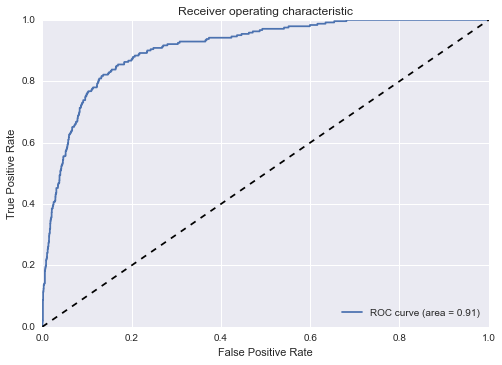

In [98]:
# Run classifier
model = LogisticRegression().fit(X_train, y_train)
probas_ = model.predict_proba(X_test)[:,1]

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_)
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
sns.set_palette("deep", desat=.8)
sns.set(font_scale=2.0)
sns.set_context(rc={"figure.figsize": (30, 10)})   
plt.show()

##Plot learning curve and cross validate

In [99]:
log_score = cross_val_score(LogisticRegression(),X,y, cv=5).mean()
print "CrossValScore: ", log_score.round(4)

CrossValScore:  0.9124


In [100]:
from sklearn.externals import joblib
joblib.dump(model, 'my_model.pkl', compress=9)

['my_model.pkl']

In [101]:
# from sklearn.externals import joblib
# model = joblib.load('my_model.pkl') 

##Apply classification to untagged questions to get high-school/non-high school

In [102]:
results = model.predict(postdatauc)

In [103]:
postdatauc['HighSchoolSubject'] = results

In [104]:
postdataml['HighSchoolSubject'] = y

In [105]:
postdatadc4.fillna(value='',inplace=True)

In [106]:
postdatadc4['Id_x'] = postdatadc4['Id_x'].astype(float)
postdatadc4['UpVotes'] = postdatadc4['UpVotes'].convert_objects(convert_numeric=True)

In [107]:
postdataml['Id_x'] = postdatadc4['Id_x'][0:sample_size]
# postdataml['Title'] = postdatadc4['Title'][0:sample_size]
# postdataml['Tags'] = postdatadc4['Tags'][0:sample_size]
postdataml['BodyLength'] = postdatadc4['BodyLength'][0:sample_size]
postdataml['ViewCount'] = postdatadc4['ViewCount'][0:sample_size]
postdataml['UpVotes'] = postdatadc4['UpVotes'][0:sample_size]
postdataml['CommentCount'] = postdatadc4['CommentCount'][0:sample_size]
postdataml['FavoriteCount'] = postdatadc4['FavoriteCount'][0:sample_size]
postdataml['LongevitySeconds'] = postdatadc4['LongevitySeconds'][0:sample_size]
# postdataml['Location'] = postdatadc4['Location'][0:sample_size]
# postdataml['Location2'] = postdatadc4['Location2'][0:sample_size]

postdatauc['Id_x'] = postdatadc4['Id_x'][sample_size:0]
# postdatauc['Title'] = postdatadc4['Title'][sample_size:0]
# postdatauc['Tags'] = postdatadc4['Tags'][sample_size:0]
postdatauc['BodyLength'] = postdatadc4['BodyLength'][sample_size:0]
postdatauc['ViewCount'] = postdatadc4['ViewCount'][sample_size:0]
postdatauc['UpVotes'] = postdatadc4['UpVotes'][sample_size:0]
postdatauc['CommentCount'] = postdatadc4['CommentCount'][sample_size:0]
postdatauc['FavoriteCount'] = postdatadc4['FavoriteCount'][sample_size:0]
postdatauc['LongevitySeconds'] = postdatadc4['LongevitySeconds'][sample_size:0]
# postdatauc['Location'] = postdatadc4['Location'][sample_size:0]
# postdatauc['Location2'] = postdatadc4['Location2'][sample_size:0]

##Mini batch K-means clustering algorithm to get topics

In [108]:
## Document Clustering
# k-means have to specify clusters
# look at inertia curve for a natural kink 
# with mini-batch k-means it is much faster (for full dataset)

# hierarchical - don't have to specify

# run mini batch k-means with a bunch of different k's
# look at inertia curve for a kink, with different k's, what is the squared distance between centroid and top'
# use cosine distance
# run aglomerative hierarchical clustering so don't need to know how many clusters
# tweak as much as time allows

In [109]:
print len(postdatadc4)

20000


In [110]:
# Within tfidf_ml pull out only rows with HighSchoolSubject == 1
tfidf_ml_hs = postdataml[postdataml.HighSchoolSubject == 1]
tfidf_uc_hs = postdatauc[postdatauc.HighSchoolSubject == 1]
print len(tfidf_ml_hs)
print len(tfidf_uc_hs)

1013
341


In [111]:
tfidf_final_hs = tfidf_ml_hs.append(tfidf_uc_hs)

In [114]:
tfidf_final_hs.columns[-10:]

Index([5605, 5606, u'HighSchoolSubject', u'Id_x', u'BodyLength', u'ViewCount', u'UpVotes', u'CommentCount', u'FavoriteCount', u'LongevitySeconds'], dtype='object')

In [115]:
tfidf_final_hs_clustering = tfidf_final_hs.ix[:,0:-8]
tfidf_final_hs_data = tfidf_final_hs.ix[:,-8:]
tfidf_final_hs_data.columns

Index([u'HighSchoolSubject', u'Id_x', u'BodyLength', u'ViewCount', u'UpVotes', u'CommentCount', u'FavoriteCount', u'LongevitySeconds'], dtype='object')

In [116]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 10

km = MiniBatchKMeans(n_clusters=num_clusters, 
                     init='k-means++', 
                     max_iter=100, 
                     batch_size=100, 
                     verbose=0, 
                     compute_labels=True, 
                     random_state=None, 
                     tol=0.0, 
                     max_no_improvement=10, 
                     init_size=None, 
                     n_init=3, 
                     reassignment_ratio=0.01)

%time km.fit(tfidf_final_hs_clustering)

clusters = km.labels_.tolist()

CPU times: user 862 ms, sys: 177 ms, total: 1.04 s
Wall time: 963 ms


In [117]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

['doc_cluster.pkl',
 'doc_cluster.pkl_01.npy',
 'doc_cluster.pkl_02.npy',
 'doc_cluster.pkl_03.npy']

In [118]:
tfidf_final_hs_data['clusters'] = clusters

In [119]:
tfidf_final_hs_data.columns

Index([u'HighSchoolSubject', u'Id_x', u'BodyLength', u'ViewCount', u'UpVotes', u'CommentCount', u'FavoriteCount', u'LongevitySeconds', u'clusters'], dtype='object')

In [120]:
tfidf_final_hs_data = tfidf_final_hs_data.to_dense()

In [121]:
tfidf_final_hs_data.head()

,BodyLength,CommentCount,FavoriteCount,HighSchoolSubject,Id_x,LongevitySeconds,UpVotes,ViewCount,clusters
4,327,1,0,1,745185,1357.863,0,63,0
11,838,1,0,1,360957,29236940.587,853,1814,0
27,183,1,0,1,684516,528.290,37,88,7
43,499,0,0,1,219174,794.536,83,57,0
53,628,0,0,1,459113,1218.747,5608,658,0


In [122]:
counter = []
for i in tfidf_final_hs_data.clusters:
    if i not in counter:
        counter.append(i)
counter

[0.0, 7.0, 4.0, 3.0, 2.0, 9.0, 8.0, 1.0, 5.0, 6.0]

In [123]:
Titletagsml = postdatadc4[['Id_x','Title','Tags','Body','HighSchoolSubject']][0:sample_size]
Titletagsuc = postdatadc4[['Id_x','Title','Tags','Body','HighSchoolSubject']][sample_size:]
Titletagsuc['HighSchoolSubject'] = results

In [124]:
Titletagsml = Titletagsml[Titletagsml.HighSchoolSubject == 1]
Titletagsuc = Titletagsuc[Titletagsuc.HighSchoolSubject == 1]

In [127]:
print len(Titletagsml)
print len(Titletagsuc)

1013
341


In [128]:
Titletags = Titletagsml.append(Titletagsuc)

In [129]:
df_final = tfidf_final_hs_data.merge(Titletags, how='left', on='Id_x')

In [130]:
df_final.index = clusters

In [131]:
df_final.clusters.value_counts()

0    483
6    170
7    127
9    120
2     96
8     92
3     88
1     83
4     57
5     38
dtype: int64

In [132]:
grouped = df_final['UpVotes'].groupby(df_final['clusters']) #groupby cluster for aggregation purposes
grouped.mean() #average rank (1 to 100) per cluster

clusters
0    204.603486
1     82.545455
2    162.657895
3    259.672414
4    172.500000
5     69.612903
6    198.024390
7    211.569231
8    245.857143
9    167.339623
Name: UpVotes, dtype: float64

In [134]:
# import os  # for os.path.basename

# import matplotlib.pyplot as plt
# import matplotlib as mpl

# from sklearn.manifold import MDS

# MDS()

# # convert two components as we're plotting points in a two-dimensional plane
# # "precomputed" because we provide a distance matrix
# # we will also specify `random_state` so the plot is reproducible.
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = dist[:, 0], dist[:, 1]
print()

()


In [135]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in df_final.ix[i]['Title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: nt, functions, know, value, derivative, question,

Cluster 0 titles: Reason for the diferentiability of function on open interval in Rolle's Theorem, Find the coordinates of any stationary points on the curve $y = {1 \over {1 + {x^2}}}$ and state it's nature, Existence of a certain interval, Understanding the role of sales tax in problems involving prices, Why do the denominators of two fractions with numerators $1$ add up to a third fraction that have the special things below?, Solutions of $n$th derivative of $(x-a)^n(x-b)^n=0$, how to factorize $x^4+2x^3+3x^2+2x+1$, How to measure spatial concentration of points of interest over a specified geographic zone?, Energy Radiating Off of a Cube Split Into Two Pieces, How do I prove $\csc^4 x-\cot^4x=(1+\cos^2x)/\sin^2x$, Average Velocity, If 8 divides $a^2$ + $3b^2$, prove that both a and b are even., With 2 lists of numbers is it possible to get the actual ratio of the sum of both lists with only 

In [136]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                 5: '#1b9e77', 6: '#d95f02', 7: '#7570b3', 8: '#e7298a', 9: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'derivation, functions, rules, differentiable, second, values', 
                 1: 'sqrt, frac, int', 
                 2: 'theta, sin, cos,frac',
                 3: 'sin, frac, cos', 
                 4: 'frac, dx, int, pi, right', 
                 5: 'solve, equations, area, answer, know',
                 6: 'tan, dfrac, log, frac',
                 7: 'line, point, circle, tangent, slope, equations',
                 8: 'integrable, dx, int, frac, ln, pi',
                 9: 'triangle, angle, length, area, abc, ab'
                }

In [145]:
len(clusters)

1354

In [140]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 
titles = df_final.Title
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

ValueError: arrays must all be same length

In [ ]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Final Analysis
    - What fundamental topics which are the pain points
    - Which clusters have the most fundamental topics?
    - Which clusters are overrepresented with fundamental topics?
    - What are fundamental topics within calculus?

##Visualizations

### Presentation
- High school is like a user experience. How can we identify when high school students as users  of the education system experience pain points which may inhibit their progress. 
- Everyone has pain points with the process. Some students are able to surmount those obstacles, while other may need targeted help to get the most out of the available system.
- Often when speaking about mathematics you hear people say that they aren't math people, or aren't good at math and you find out that they hit a wall. It's like anything in life which is difficult. You hit a wall and you either push through it or you don't. 
- present it as a paradigm which is a process which can be improved upon. there are answers that we can deivgn about how to teach people that are better or worse than others. Testing to figure out where are the pain points and where are students falling behind, particularly in math/science. 
- These are users /consumers of education. 
- I'm building a tool which can target at what point students are exiting the process. 